# Calculating isotherm depth using pure python

Code blocks for project reference.

### Low memory version (no dask)

This code block is for computing isotherm depth per timestep sample. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

modeldir='/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f09_g17.CMIP6-piControl.001'
modelsub='/ocn/proc/tseries/month_1/'
filename=f'{modeldir}{modelsub}b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.TEMP.000101-009912.nc'

# Open dataset
ds = xr.open_dataset(filename, decode_timedelta=True)
ds = ds.isel(time=0)

target_temp = 20.0
z_t = ds['z_t'].values / 100.0
TEMP = ds['TEMP'].values  # shape: (z_t, nlat, nlon)

depth_at_target = np.full(TEMP.shape[1:], np.nan)  # (nlat, nlon)

for i in range(TEMP.shape[1]):        # nlat
    for j in range(TEMP.shape[2]):    # nlon
        profile = TEMP[:, i, j]
        if np.any(~np.isnan(profile)):
            try:
                depth_at_target[i, j] = np.interp(target_temp, profile[::-1], z_t[::-1])
            except ValueError:
                pass  # temperature outside profile

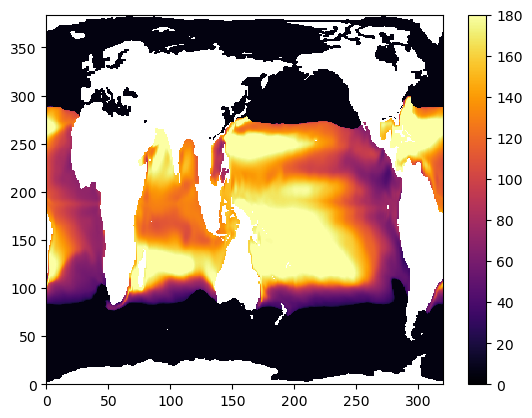

In [2]:
cb = plt.pcolormesh(depth_at_target, vmin=0, vmax=180, cmap='inferno') 
plt.colorbar(cb)
plt.show()

### Low memory version (no dask)

This code block is for computing isotherm depth per timestep sample, but with further clean up (e.g., assignment of nan and formal metadata). 

In [3]:
import xarray as xr
import numpy as np

# --- Config ---
modeldir = "/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f09_g17.CMIP6-piControl.001"
modelsub = "/ocn/proc/tseries/month_1/"
filename = f"{modeldir}{modelsub}b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.TEMP.000101-009912.nc"

target_temp = 20.0  # °C
time_index = 0

# --- Load one time slice ---
ds = xr.open_dataset(filename, decode_timedelta=True)
T = ds["TEMP"].isel(time=time_index)

# Rename vertical dim to 'z' and convert its coordinate from cm -> m
T = T.rename({"z_t": "z"})
T = T.assign_coords(z=(T["z"] / 100.0))
T["z"].attrs.update(units="m", long_name="depth")

# --- First downward-crossing interpolation of the target isotherm ---
S = T - target_temp
crossing = (S >= 0) & (S.shift(z=-1) < 0)     # True at the upper level of a crossing pair
has_cross = crossing.any("z")
k = crossing.argmax("z")                       # first crossing index along z

# Bracketing (k, k+1) values using vectorized indexing
T0 = T.isel(z=k)
T1 = T.shift(z=-1).isel(z=k)
Z0 = T["z"].isel(z=k)
Z1 = T["z"].shift(z=-1).isel(z=k)

denom = T1 - T0
depth_iso = xr.where(
    has_cross & np.isfinite(denom),
    Z0 + (target_temp - T0) * (Z1 - Z0) / denom,
    np.nan
)

depth_iso = depth_iso.rename(f"depth_at_{int(target_temp)}c").assign_attrs(
    units="m",
    long_name=f"Depth of {target_temp}°C isotherm (first downward crossing)"
)

# Example quicklook / save
# depth_iso.plot()
# depth_iso.to_netcdf(f"isotherm_depth_{int(target_temp)}c.nc")

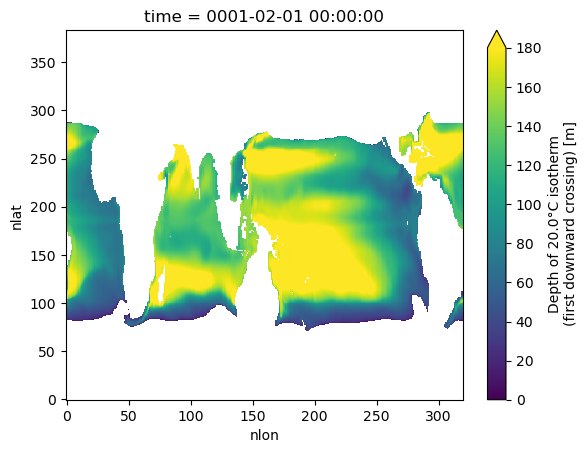

In [4]:
depth_iso.plot.pcolormesh(vmin=0, vmax=180)

### Dask/parallel version

Needs to be run on a job and with dask.

In [ ]:
import xarray as xr
import numpy as np

def depth_of_isotherm_all_times(T_in, target):
    """
    Compute depth of the target isotherm for all times, vectorized over the grid.

    Parameters
    ----------
    T_in : xarray.DataArray
        Temperature with dims ('time', 'z_t', 'nlat', 'nlon') or ('z_t','nlat','nlon').
        POP 'z_t' is expected (in cm).
    target : float or sequence of floats
        Isotherm temperature(s) in °C. If a sequence, returns an extra dim 'iso'.

    Returns
    -------
    depth_iso : xarray.DataArray
        Depth (m) of the first downward crossing of the isotherm.
        Dims: same as T_in minus 'z_t'; plus 'iso' if multiple targets.
        Values are NaN where no crossing occurs.
    """
    # Ensure we have a 'z' dim with meters
    T = T_in.rename({"z_t": "z"}) if "z_t" in T_in.dims else T_in
    T = T.assign_coords(z=(T["z"] / 100.0))
    T["z"].attrs.update(units="m", long_name="depth")

    # Broadcast target(s)
    if np.ndim(target) == 0:
        # scalar target, keep as plain float (xarray will broadcast)
        targets = None
        S = T - target
    else:
        # multiple targets -> add an 'iso' dimension
        targets = xr.DataArray(np.asarray(target), dims=["iso"], name="iso_values")
        S = T.expand_dims(iso=targets.sizes["iso"]) - targets[:, None, None, None]

    # Find first downward crossing along depth: S>=0 at z_k and S<0 at z_{k+1}
    crossing = (S >= 0) & (S.shift(z=-1) < 0)  # True at upper level of the crossing pair
    has_cross = crossing.any("z")
    k = crossing.argmax("z")  # index of first True along z (0 if none; we’ll mask by has_cross)

    # Gather bracketing levels z_k and z_{k+1}
    T0 = T.isel(z=k)
    T1 = T.shift(z=-1).isel(z=k)
    Z0 = T["z"].isel(z=k)
    Z1 = T["z"].shift(z=-1).isel(z=k)

    # Interpolate: Z = Z0 + (target - T0) * (Z1 - Z0) / (T1 - T0)
    denom = (T1 - T0)

    if targets is None:
        tgt = target
    else:
        # Align target values to T0’s dims (time, nlat, nlon, iso or iso, time, nlat, nlon depending on order)
        tgt = targets
        # Make sure broadcasting matches T0
        for d in T0.dims:
            if d not in tgt.dims:
                tgt = tgt.broadcast_like(T0)

    depth_iso = xr.where(
        has_cross & np.isfinite(denom),
        Z0 + (tgt - T0) * (Z1 - Z0) / denom,
        np.nan
    )

    # Nice naming/attrs
    if targets is None:
        depth_iso = depth_iso.rename(f"depth_at_{int(target)}c")
        long_name = f"Depth of {target}°C isotherm (first downward crossing)"
    else:
        depth_iso = depth_iso.rename("depth_of_isotherm")
        long_name = "Depth of isotherms (first downward crossing)"
        depth_iso = depth_iso.assign_coords(iso=targets.values)

    return depth_iso.assign_attrs(units="m", long_name=long_name)


# --- Example usage on your file: all times at once ---
modeldir = "/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f09_g17.CMIP6-piControl.001"
modelsub = "/ocn/proc/tseries/month_1/"
filename = f"{modeldir}{modelsub}b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.TEMP.000101-009912.nc"

ds = xr.open_dataset(filename, decode_timedelta=True)  # optionally add chunks for dask
T_all = ds["TEMP"]  # dims: time, z_t, nlat, nlon

# Single isotherm for all times
depth20 = depth_of_isotherm_all_times(T_all, 20.0)

# Multiple isotherms at once (returns extra 'iso' dim)
depth_multi = depth_of_isotherm_all_times(T_all, [10.0, 15.0, 20.0, 25.0])

# Quick checks:
# depth20.isel(time=0).plot()         # map at first time
# depth_multi.sel(iso=20.0).plot()    # should match depth20
# depth20.to_netcdf("depth_20C_alltimes.nc")

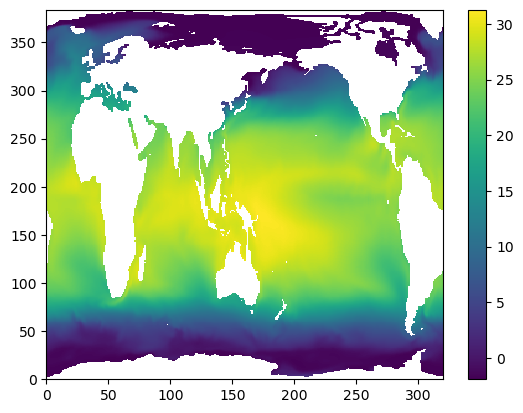

In [19]:
cb = plt.pcolormesh(TEMP[0])
plt.colorbar(cb)
plt.show()